In [1]:
from torch.distributions.beta import Beta


In [16]:
B = Beta(1.0, 1.0)
y = [B.sample() for _ in range(10000)]

In [17]:
import matplotlib.pyplot as plt

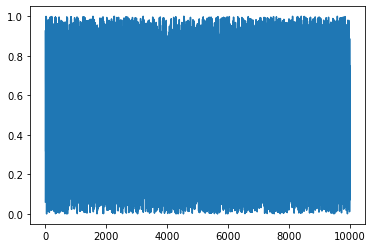

In [18]:
plt.plot(y)